In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
kaggleMoviesDataPath = '/kaggle/input/movie-recommendation-system-dataset/movies.csv'
kaggleTagsDataPath = '/kaggle/input/movie-recommendation-system-dataset/tags.csv'

moviesData = pd.read_csv(kaggleMoviesDataPath, encoding = 'utf-8')
tagsData = pd.read_csv(kaggleTagsDataPath, encoding = 'utf-8')

In [3]:
moviesData.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tagsData.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


In [5]:
print(moviesData.shape)
print(tagsData.shape)

(87585, 3)
(2000072, 4)


In [6]:
moviesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [7]:
tagsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 61.0+ MB


In [8]:
for col in moviesData.columns:
    print(f'*{col}* has *{moviesData[col].nunique()}* unique values and {moviesData[col].isnull().sum()} null values')
print()
for col in tagsData.columns:
    print(f'*{col}* has *{tagsData[col].nunique()}* unique values and {tagsData[col].isnull().sum()} null values')

*movieId* has *87585* unique values and 0 null values
*title* has *87382* unique values and 0 null values
*genres* has *1798* unique values and 0 null values

*userId* has *15848* unique values and 0 null values
*movieId* has *51323* unique values and 0 null values
*tag* has *140979* unique values and 17 null values
*timestamp* has *1291250* unique values and 0 null values


## 2. `Data Preprocessing/Cleaning`

In [9]:
moviesData['genres'][:5].values

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy'], dtype=object)

➡️ 'genres' column has genres divided by a '|', we need to change this.

In [10]:
moviesData['genres'] = moviesData['genres'].str.replace('|', ' ', regex=False)

In [11]:
moviesData[['genres']][:5]

,genres
0,Adventure Animation Children Comedy Fantasy
1,Adventure Children Fantasy
2,Comedy Romance
3,Comedy Drama Romance
4,Comedy


In [12]:
# This replaces the empty tags with just a empty space
tagsData['tag'] = tagsData['tag'].apply(lambda x: '' if pd.isna(x) else str(x))

In [13]:
groupedTagsData = tagsData.groupby('movieId')['tag'].apply(lambda x: ' '.join(list(set(x)))).reset_index()
df = pd.merge(moviesData, groupedTagsData, on='movieId', how='left')

In [14]:
#this is the new and latest dataset with all the features
df.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,dachshund rescue neighborhood CGI very good vi...
1,2,Jumanji (1995),Adventure Children Fantasy,plant excavation animals forest reference to l...
2,3,Grumpier Old Men (1995),Comedy Romance,comedinha de velhinhos engraÃ§ada fishing old ...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,divorce characters CLV chick flick interracial...
4,5,Father of the Bride Part II (1995),Comedy,regret steve martin CLV seen 2021 Steve Martin...


In [15]:
# these are the tags for a single movie
df['tag'][0]

"dachshund rescue neighborhood CGI very good villain arcade light anthropomorphism neighbor soldier toy story 2009 reissue in Stereoscopic 3-D fun family movie asking directions running famous line little girl bedroom thunderstorm HEROIC MISSION hasbro chasing a truck battleship game child destroys another's toy subjective camera UNLIKELY FRIENDSHIPS national film registry toy robot parachute lifting someone into the air walkie talkie moving toyota magic 8 ball false accusation bouncy ball clever loyal friend disney famous song rain torture bullying blockbuster children cartoon storage shed nostalgic doubt accepting reality innovative fireplace buddy movie rocket children radio controlled unny flying candy land the board game staircase violence cartoon childish National Film Registry boy next door Engaging remote controlled toy car adventure Owned 3d favorite frustration shark tom hanks classic child's birthday party scene during opening credits 3 dimensional lipstick on face turbo boo

In [16]:
df['tag'] = df['tag'].fillna('')

In [17]:
df['combined_features'] = df['genres'] + ' ' + df['tag']
df.head()

,movieId,title,genres,tag,combined_features
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,dachshund rescue neighborhood CGI very good vi...,Adventure Animation Children Comedy Fantasy da...
1,2,Jumanji (1995),Adventure Children Fantasy,plant excavation animals forest reference to l...,Adventure Children Fantasy plant excavation an...
2,3,Grumpier Old Men (1995),Comedy Romance,comedinha de velhinhos engraÃ§ada fishing old ...,Comedy Romance comedinha de velhinhos engraÃ§a...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,divorce characters CLV chick flick interracial...,Comedy Drama Romance divorce characters CLV ch...
4,5,Father of the Bride Part II (1995),Comedy,regret steve martin CLV seen 2021 Steve Martin...,Comedy regret steve martin CLV seen 2021 Steve...


In [19]:
# reducing the size, because more size, more ram comsumption
print(df.shape)
# 40000 rows are done in kaggle which uses approx 12Gb of ram (better to run with 16Gb of system ram).
df = df.head(40000)
df.head()

(87585, 5)


➡️ Its time to filter out any stopwords in the genres, because with this feature we are going to predict the movies best suitable for the user

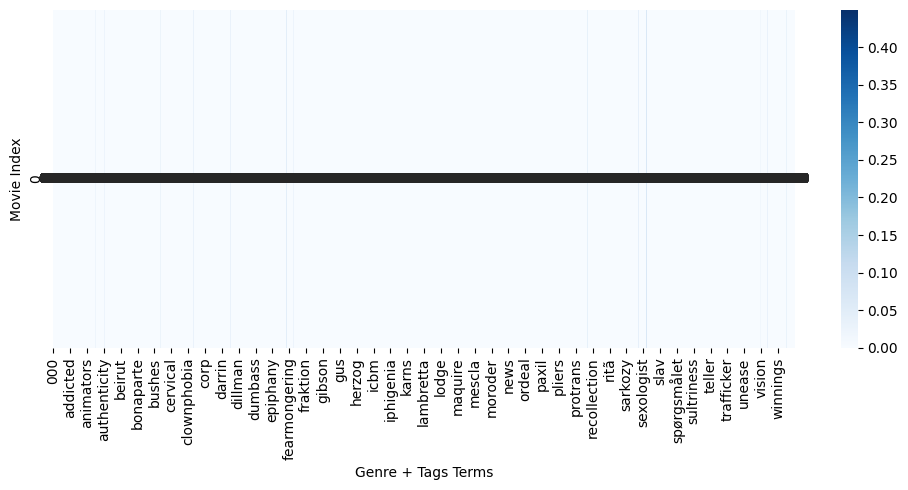

In [20]:
# with this we remove the stopwords.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

feature_names = tfidf.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix[:1][:10].toarray(), columns=feature_names)

plt.figure(figsize = (10,5))
sns.heatmap(df_tfidf, annot = True, fmt=".2f", cmap='Blues')
plt.xlabel("Genre + Tags Terms")
plt.ylabel("Movie Index")
plt.tight_layout()
plt.show()

## 3. `Similarity Training`

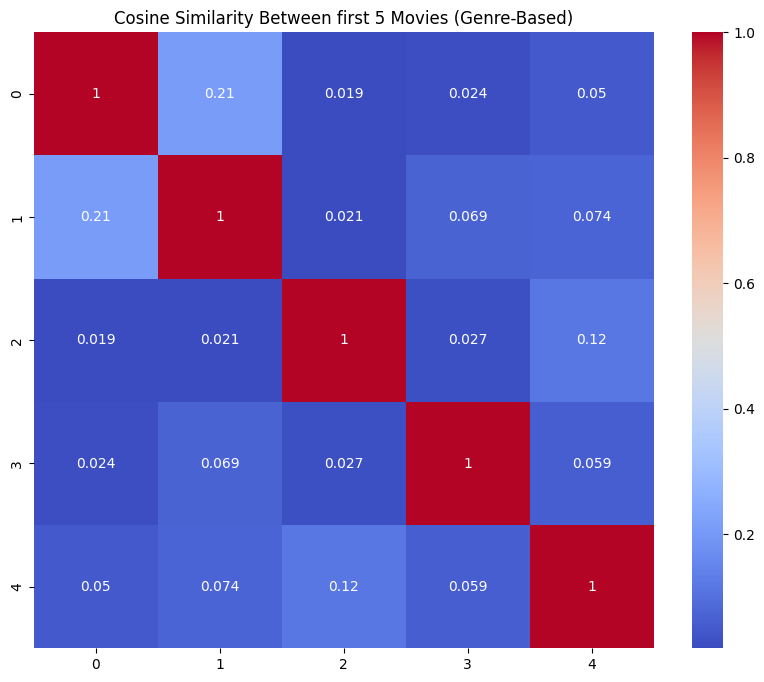

In [21]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim[:5, :5], cmap='coolwarm', annot = True)
plt.title("Cosine Similarity Between first 5 Movies (Genre-Based)")
plt.show()

In [22]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
indices["Jumanji (1995)"]

1

In [23]:
df.head()

,movieId,title,genres,tag,combined_features
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,dachshund rescue neighborhood CGI very good vi...,Adventure Animation Children Comedy Fantasy da...
1,2,Jumanji (1995),Adventure Children Fantasy,plant excavation animals forest reference to l...,Adventure Children Fantasy plant excavation an...
2,3,Grumpier Old Men (1995),Comedy Romance,comedinha de velhinhos engraÃ§ada fishing old ...,Comedy Romance comedinha de velhinhos engraÃ§a...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,divorce characters CLV chick flick interracial...,Comedy Drama Romance divorce characters CLV ch...
4,5,Father of the Bride Part II (1995),Comedy,regret steve martin CLV seen 2021 Steve Martin...,Comedy regret steve martin CLV seen 2021 Steve...


In [24]:
# This functions returns the top 10 most similar movies to "title"
def recommend(title, n=10):
    try:
        if title not in indices.index:
            return f"❌ Movie '{title}' not found!"
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n+1]

        movie_indices = [i[0] for i in sim_scores]
        return moviesData['title'].iloc[movie_indices]
        
    except Exception as e:
        raise e

recommend('Jumanji (1995)')

581                   Terminator 2: Judgment Day (1991)
1237                          Back to the Future (1985)
1922                  Back to the Future Part II (1989)
3602                                     Mad Max (1979)
30107    Fantastic Beasts and Where to Find Them (2016)
13823                                 Zombieland (2009)
14554           Black Waters of Echo's Pond, The (2009)
1013                                    Die Hard (1988)
16096                                Drive Angry (2011)
437                               Demolition Man (1993)
Name: title, dtype: object